# Validation curves
Ploting the validation curves for the dragnet dataset

In [1]:
%matplotlib inline
# standard library
import itertools
import sys, os
import re
import glob
import shutil

# pandas
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask


# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# skealrn
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score

# tesnsorflow
import tensorflow as tf

# local imports
sys.path.append(os.path.join(os.getcwd(), "../src"))

import tf_utils, tf_experiments

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

In [ ]:
# define some constants
RANDOM_SEED = 42
BEST_CHECKPOINT_PATH = '/home/nikitautiu/models/best/best_dragnet.ckpt'
MODEL_DIR = '/home/nikitautiu/models/dragnet_curves/'

## Inputting the data
Using our in-memory caching dataset, we are going to load all the 3 datasets(train, validation, test) in memory.

In [ ]:
# get the input functions and the initialization hooks to pass to the estimator
test_input_fn, test_init_hook = tf_utils.input_fn_from_csv('../data/final/dragnet/dom-full-test-*.csv', precache=True)
train_input_fn, train_init_hook = tf_utils.input_fn_from_csv('../data/final/dragnet/dom-full-train-*.csv', precache=True)
validation_input_fn, validation_init_hook = tf_utils.input_fn_from_csv('../data/final/dragnet/dom-full-validation-*.csv', precache=True)

# define some shorthands
train_train_fn = lambda: train_input_fn(num_epochs=5, batch_size=2000, shuffle_buffer=50000)
train_eval_fn = lambda: train_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0)
validation_fn = lambda: validation_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0)
test_fn = lambda: test_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0)

## Defining the model


In [ ]:
# session workaround
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True

config = tf.estimator.RunConfig(
    model_dir=MODEL_DIR,
    save_checkpoints_steps=1000, 
    session_config=sess_config, 
    tf_random_seed=RANDOM_SEED
)

# we can infer the columns from the function, a bit costly, but better than hardcoding
tf_feat_cols = tf.contrib.learn.infer_real_valued_columns_from_input_fn(train_eval_fn)
estimator = tf.estimator.DNNClassifier(feature_columns=tf_feat_cols, hidden_units=(1000, 500, 200), 
                                        weight_column='weights', config=config)


Now that we have the model, we can build the infrastructure  for testing out the training process and returning the losses and other metrics.

## Train loop
We are running the train/eval loop for 1500 epochs. The best models for validation are persisted

In [ ]:
%%time
metrics = tf_experiments.train_eval_loop(
    estimator=estimator, 
    train_input_fn_and_hook=(train_train_fn, train_init_hook),
    num_epochs=1500, epoch_step=5,
    eval_input_fns_and_hooks={'train':(train_eval_fn, train_init_hook), 'validation': (validation_fn, validation_init_hook)},
    save_on_metric='f1-score', best_checkpoint_path=BEST_CHECKPOINT_PATH, save_set_name='validation'
)

The training/validation process takes roughlt 14 hours to complete.

## Results and vizualization

In [16]:
# retrieve the test metrics
test_metrics = tf_experiments.get_metrics(
    estimator=estimator, input_fn=test_fn, 
    init_hooks=[test_init_hook], checkpoint_path=BEST_CHECKPOINT_PATH,
)

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/best/best_dragnet.ckpt


In [17]:
validation_stats = pd.DataFrame(metrics['validation'])
train_stats = pd.DataFrame(metrics['train'])
# set the epoch for the test stats from the best epoch of the validation
test_metrics['epoch'] =  validation_stats.loc[validation_stats['f1-score'].idxmax(), 'epoch']
test_stats = pd.DataFrame([test_metrics])  # build the df out of it

In [18]:
best_epoch = validation_stats.loc[validation_stats['f1-score'].idxmax(), 'epoch']
best_index = test_stats['epoch'] == best_epoch


print('BEST VALIDATION EPOCH - VALIDATION RESULTS')
print(validation_stats[validation_stats['epoch'] == best_epoch])
print('BEST VALIDATION EPOCH - TEST RESULTS')
print(test_stats[test_stats['epoch'] == best_epoch])

BEST VALIDATION EPOCH - VALIDATION RESULTS
     accuracy  epoch  f1-score  precision    recall  support  support_other
119  0.999829    600   0.99818   0.999271  0.997091     8249         167329
BEST VALIDATION EPOCH - TEST RESULTS
   accuracy  epoch  f1-score  precision   recall  support  support_other
0  0.999598  600.0  0.995314   0.999545  0.99112     6644         147721


### Accuracy

(<matplotlib.figure.Figure at 0x7f7afc07d518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7afc074e48>)

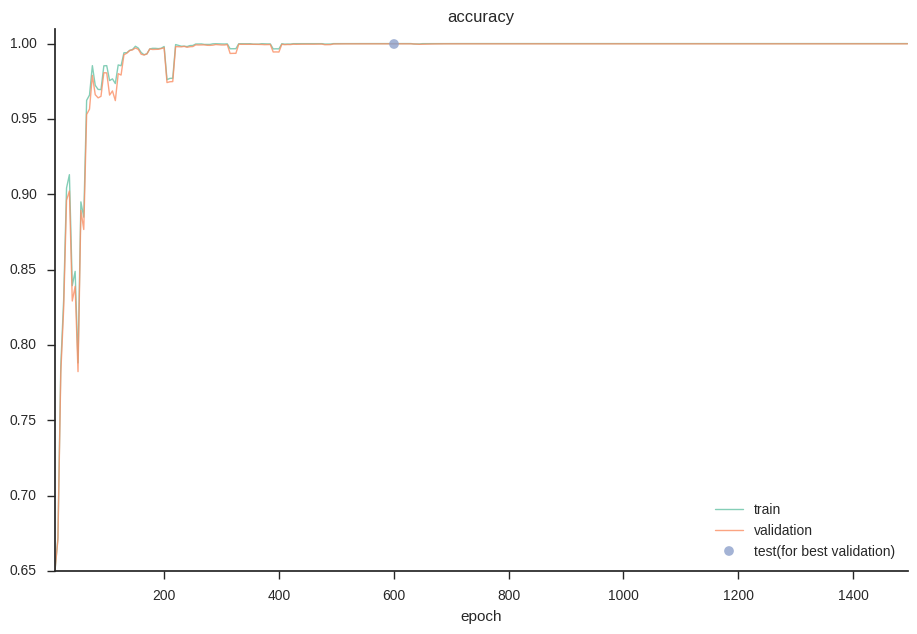

In [26]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'accuracy', smoothing=3)

### Precision/Recall

(<matplotlib.figure.Figure at 0x7f7ad0274a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7b1c07e0b8>)

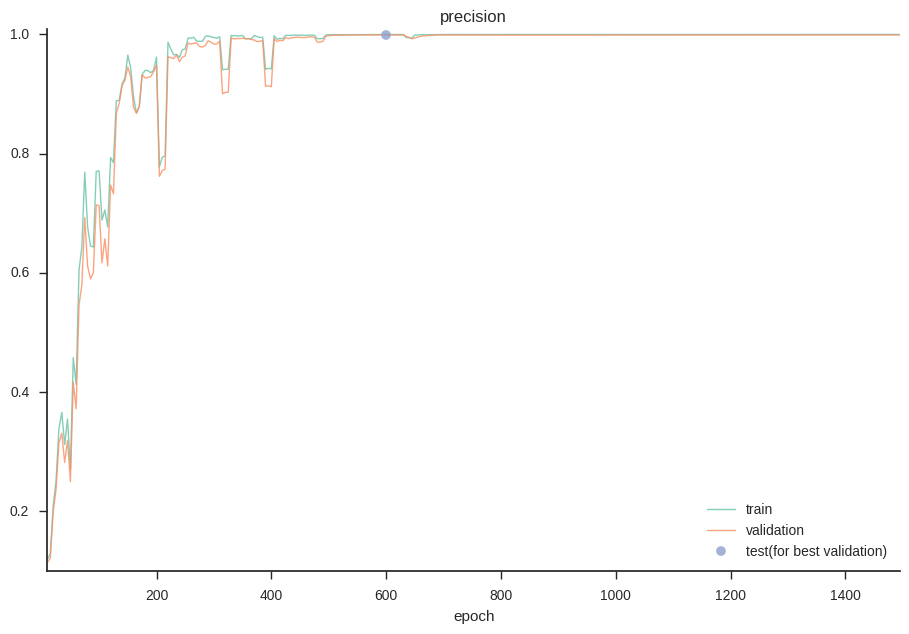

In [27]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'precision', smoothing=3)

(<matplotlib.figure.Figure at 0x7f7acf9e11d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7acf9cc780>)

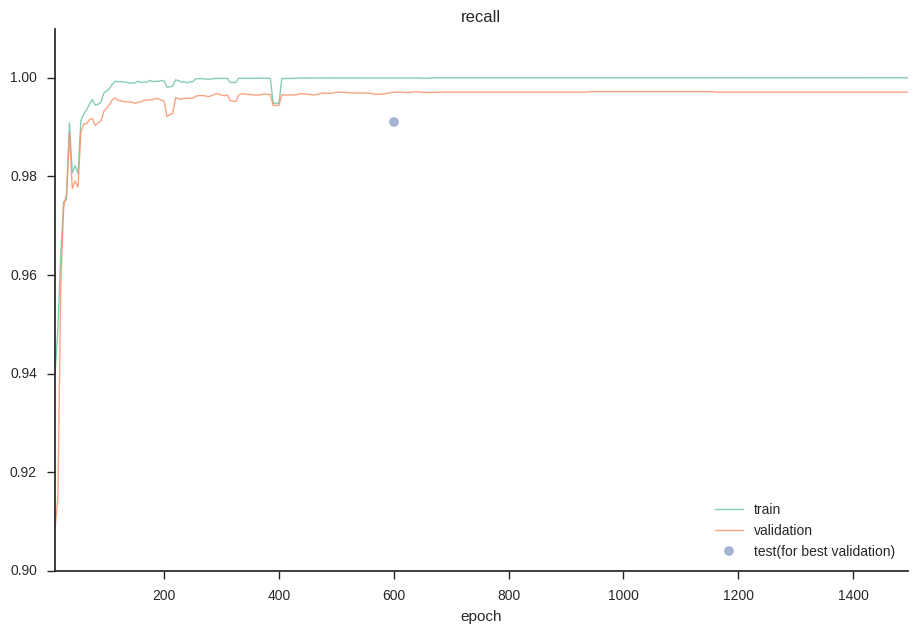

In [28]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'recall', smoothing=3)

### F1-Score

(<matplotlib.figure.Figure at 0x7f7ad6104860>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7ad6108400>)

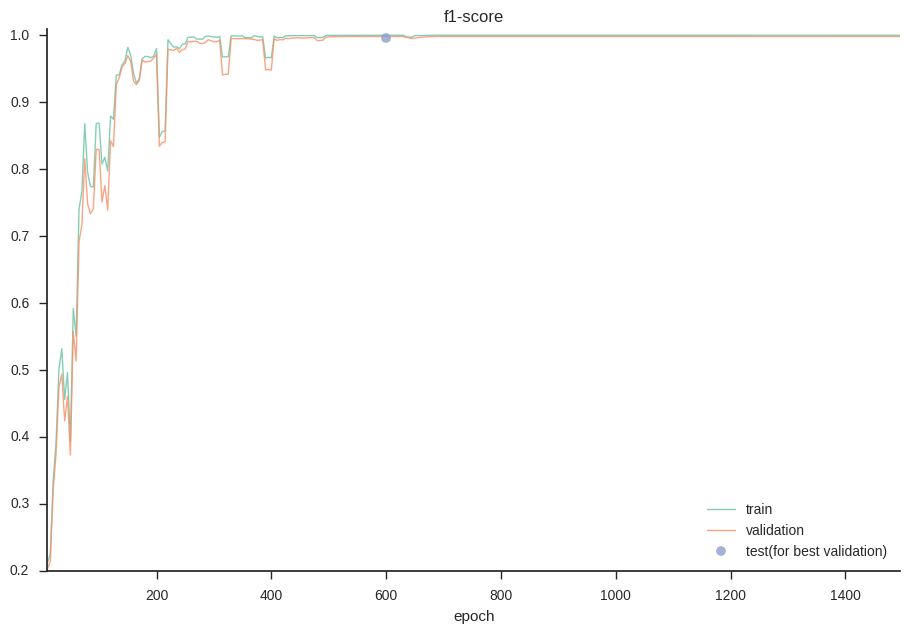

In [29]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'f1-score', smoothing=3)

### Misc stats

In [23]:
# see the best values indxes for validation
validation_stats.idxmax()

accuracy         119
epoch            299
f1-score         119
precision        119
recall           126
support            0
support_other      0
dtype: int64

In [40]:
# also, here are the stats averaged over a rolling window of 50, resample in 50 steps
validation_stats.rolling(3, center=True).mean().dropna().iloc[::10].set_index('epoch').drop(['support', 'support_other'], axis=1)

,accuracy,f1-score,precision,recall
epoch,,,,
10.0,0.650989,0.202807,0.114549,0.908595
60.0,0.876621,0.513328,0.371972,0.990666
110.0,0.968567,0.775309,0.657216,0.995555
160.0,0.992930,0.931284,0.877559,0.995111
210.0,0.974648,0.839626,0.771725,0.992524
260.0,0.999066,0.990122,0.983920,0.996404
310.0,0.999311,0.992700,0.988873,0.996565
360.0,0.999501,0.994696,0.992876,0.996525
410.0,0.999267,0.992243,0.988056,0.996484


In case we need them later, we will persist the results.

In [25]:
pd.concat([train_stats.assign(set='train'), 
           validation_stats.assign(set='validation'), 
           test_stats.assign(set='test')]).to_csv('../data/experimental-results/dragnet-validation-curves.csv')

## Conclusion
Unlike in the cleaneval case, we can see very quick convergence of the model at around epoch 600. All of the performance metrics max out around that time and although the diferences are not clearly observable in thep plot, it means overfitting does indeed occur on the training set. 

Perhaps this is most evident on hte recall plot where a slight decrease can be observed from that point on.